# The Result fron logistic regression:

Accuracy: 0.5240346729708432



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       604
           1       0.52      1.00      0.69       665

    accuracy                           0.52      1269
   macro avg       0.26      0.50      0.34      1269
weighted avg       0.27      0.52      0.36      1269

ROC AUC : 0.48058556988497736

In [7]:
pip install pandas_ta

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import holidays 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pandas_ta as ta
import numpy as np
from statsmodels.tsa.stattools import adfuller

data = '2012-12-30'

path_stock = "../data/stock"
path_fed = "../data/fed"

# MSFT Companies based on Market Cap

In [8]:

MSFT_df = pd.read_csv(f"{path_stock}/MSFT_stock.csv")


## Tach companies stock Data Frame processing
- Remove the null / header
- Make some features Engineering
- Change the column name
- Change the time type

In [6]:
import pandas as pd

def process_stock_data(df, ticker_symbol):
    """
    Processes a stock data DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with stock data (Price, Close, High, Low, Open, Volume, Ticker).
        ticker_symbol (str): Stock ticker symbol (e.g., 'AAPL').

    Returns:
        pd.DataFrame: Processed DataFrame with calculated features and renamed columns.
    """
    df.dropna(inplace=True)  # Remove rows containing any missing values.

    columns_to_convert = ['Close', 'High', 'Low', 'Open', 'Volume']
    df[columns_to_convert] = df[columns_to_convert].astype(float)  # Convert specified price/volume columns to floating-point numbers.

    # Calculate new features based on price data:
    df["delta_price"] = df["High"] - df["Low"]  # Calculate the difference between the high and low price for each day.
    df["avg_price"] = (df["Close"] + df["High"] + df["Low"] + df["Open"]) / 4  # Calculate the average of the close, high, low, and open prices.
    df["price_ratio"] = df["delta_price"] / df["avg_price"]  # Calculate the ratio of the delta price to the average price.
    df["invest"] = df["Volume"] * df["avg_price"]  # Calculate the difference between the trading volume and the average price (note: this might not be a standard financial metric and could be re-evaluated).

    # Rename the columns for clarity and to include the ticker symbol:
    df.rename(columns={"Price": "date",  # Rename the 'Price' column to 'date'.
                        "Close": f"close_{ticker_symbol}",  # Rename 'Close' to 'cl_ticker'.
                        "High": f"high_{ticker_symbol}",  # Rename 'High' to 'hi_ticker'.
                        "Low": f"low_{ticker_symbol}",  # Rename 'Low' to 'lo_ticker'.
                        "Open": f"open_{ticker_symbol}",  # Rename 'Open' to 'op_ticker'.
                        "delta_price": f"delta_price_{ticker_symbol}",  # Rename 'delta_price' to 'de_ticker'.
                        "avg_price": f"avg_price_{ticker_symbol}",  # Rename 'avg_price' to 'av_ticker'.
                        "invest": f"invest_{ticker_symbol}",  # Rename 'invest' to 'va_ticker'.
                        "price_ratio": f"price_ratio_{ticker_symbol}",  # Rename 'ratio' to 'ra_ticker'.
                        'Volume': f'volume_{ticker_symbol}'}, inplace=True)  # Rename 'Volume' to 'Vo_ticker'.

    df['date'] = pd.to_datetime(df['date'])  # Convert the 'date' column to datetime objects for proper time series handling.

    df.reset_index(drop=True, inplace=True)  # Reset the DataFrame's index to a default integer index and drop the original index.

    # Drop the 'Ticker' column as the ticker information is now embedded in the column names:
    if 'Ticker' in df.columns:
        df.drop('Ticker', axis=1, inplace=True)

    return df  # Return the processed DataFrame.

### Tech companies stock clean Data Frame 

In [9]:
MSFT_clean_df = process_stock_data(MSFT_df, 'MSFT')


###  Find the Max and Min od Data column in each companies stock Data Frame

In [10]:
stock_data_ranges = {}

dataframes = {

    "MSFT": MSFT_clean_df
   
}

for name, df in dataframes.items():
    if 'date' in df.columns:
        min_date = df['date'].min()
        max_date = df['date'].max()
        stock_data_ranges[name] = {'min_date': min_date, 'max_date': max_date}
    else:
        print(f"Warning: 'date' column not found in {name}_clean_df")

# Create a Pandas DataFrame to display the results
date_range_df = pd.DataFrame.from_dict(stock_data_ranges, orient='index')
date_range_df.index.name = 'Stock'

print(date_range_df)

        min_date   max_date
Stock                      
MSFT  2000-01-03 2025-04-21


In above result , It seems that the META is started from 2012 while almost the others started from 2000.

## Macro Indicators from Yahoo Finance:
- Indices
- Commodities
- Sector ETFs (Proxies)
- Other Market Metrics

In [11]:
macro_df = pd.read_csv(f"{path_stock}/macro_indicators_full.csv")
# Convert the 'date' column to datetime objects
macro_df['Date'] = pd.to_datetime(macro_df['Date'])
macro_df.rename(columns={"Date": "date"}, inplace=True)

In [ ]:
macro_df.isnull().sum()

Data Frame : macro_df ---> Has some missing values that need to be check according to the time. 

Let Filter the time after the '2012-05-31'. This is exactly after the time which we have the META stock data frame. 

In [ ]:
macro_df_filter = macro_df[macro_df['date'] > data ]
min_date_macro_df_filter = macro_df_filter['date'].min()
max_date_macro_df_filter = macro_df_filter['date'].max()
macro_df_filter.isnull().sum()

In [33]:
#macro_df_filter = macro_df_filter.drop('Brent_Crude_Futures',axis=1)

In [ ]:
df = macro_df_filter
data_name = 'macro_df_filter'
# 1. Matrix Plot: Visualize the pattern of missingness
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title(f'Missing Value Matrix - {data_name}')
plt.show()

In [ ]:
macro_clean_df = macro_df_filter.dropna()
macro_clean_df.isnull().sum()

# Fed Data frame

In [36]:
fed_df = pd.read_csv(f"{path_fed}/combined_economic_indicators.csv")

# Rename the 'Unnamed: 0' column to 'date'
fed_df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)

# Convert the 'date' column to datetime objects
fed_df['date'] = pd.to_datetime(fed_df['date'])

In [ ]:
fed_df.isnull().sum()

In [ ]:
fed_df_filter = fed_df[fed_df['date'] > data]
min_date_fed_df_filter = fed_df_filter['date'].min()
max_date_fed_df_filter = fed_df_filter['date'].max()
fed_df_filter.isnull().sum()

In [ ]:
df = fed_df_filter
data_name = 'fed_df_filter'
# 1. Matrix Plot: Visualize the pattern of missingness
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title(f'Missing Value Matrix - {data_name}')
plt.show()

In [ ]:
fed_clean_df = fed_df_filter[['date', 'cpi', 'fed_rate', 'consumer_confidence','vix', 'oil', 'nonfarm_payrolls',
       'treasury_yield', 'industrial_production', 'retail_sales', 'pmi',
        'day_of_week', 'is_holiday', 'is_working_day']].dropna()
fed_clean_df.isnull().sum()

# Merging the Date Frames

In [41]:
# Start with the first DataFrame
merged_stock_data = AAPL_clean_df.copy()

# List of stock DataFrames (excluding the first one)
stock_dfs = [MSFT_clean_df, GOOGL_clean_df, NVDA_clean_df, AMZN_clean_df,
             META_clean_df, TSLA_clean_df, AVGO_clean_df, AMD_clean_df, CRM_clean_df]

# Merge each stock DataFrame on 'date' using a left join
for df in stock_dfs:
    merged_stock_data = pd.merge(merged_stock_data, df, on='date', how='inner')

# 2. Merge with Macro and Fed DataFrames

# Merge stock data with macro data
merged_data = pd.merge(merged_stock_data, macro_clean_df, on='date', how='inner')

# Merge with fed data
final_merged_df = pd.merge(merged_data, fed_clean_df, on='date', how='inner')

stock_df = merged_stock_data
stock_macro_df = merged_data
stock_macro_fed_df = final_merged_df

# Top 10 Companies Investment over Time

In [ ]:
stock_plot = stock_macro_fed_df[[
    'date',
    'invest_AAPL','invest_MSFT','invest_GOOGL','invest_NVDA','invest_AMZN',
    'invest_META','invest_TSLA','invest_AVGO','invest_AMD','invest_CRM',
]]

plt.figure(figsize=(12, 6))  # Adjust figure size for better date visibility

# Plot each investment column against 'date'
for column in stock_plot.columns:
    if column != 'date':  # Exclude the 'date' column from the y-axis
        plt.plot(stock_plot['date'], stock_plot[column], label=column)

plt.xlabel('Date')
plt.ylabel('Investment Value')
plt.title('Investment over Time')
plt.legend(loc='upper left')  # Add legend to distinguish lines
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


# Federal Indicators Over Time 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fed_date = stock_macro_fed_df[[
    'date', 'cpi', 'fed_rate', 'consumer_confidence', 'vix', 'oil',
    'nonfarm_payrolls', 'treasury_yield', 'industrial_production', 'retail_sales', 'pmi'
]]

# Set 'date' as index for easier plotting
if 'date' in fed_date.columns:
    fed_date['date'] = pd.to_datetime(fed_date['date'])
    fed_date.set_index('date', inplace=True)
else:
    print("Error: 'date' column not found in fed_date DataFrame.")
    exit()

# --- Assess Data Ranges and Scales ---
print("Data Ranges and Scales:")
for column in fed_date.columns:
    print(f"- {column}: Range [{fed_date[column].min():.2f}, {fed_date[column].max():.2f}], Scale: {np.ptp(fed_date[column]):.2f}")

# --- Updated Plotting with Adjusted Scale ---
plt.figure(figsize=(15, 8))  # Increased figure size for better readability

for column in fed_date.columns:
    plt.plot(fed_date.index, fed_date[column], label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Federal Indicators Over Time (Raw Scale)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plotting with Standardized Scale ---
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
fed_date_scaled = fed_date.copy()
fed_date_scaled[fed_date_scaled.columns] = scaler.fit_transform(fed_date_scaled)

plt.figure(figsize=(15, 8))

for column in fed_date_scaled.columns:
    plt.plot(fed_date_scaled.index, fed_date_scaled[column], label=column)

plt.xlabel('Date')
plt.ylabel('Standardized Value (Mean=0, Std=1)')
plt.title('Federal Indicators Over Time (Standardized Scale)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Macro Indicators Over Time 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# --- Plotting with Standardized Scale ---
from sklearn.preprocessing import StandardScaler

macro_date = stock_macro_fed_df[[
    'date', 'S&P500_Index', 'Dow_Jones_Index', 'NASDAQ_Composite',
    'Russell2000_Index', 'VIX_Index', 'Dollar_Index_DXY', 'Gold_Futures',
    'WTI_Oil_Futures', 'Copper_Futures', 'Brent_Crude_Futures',
    'Tech_Sector_ETF', 'Energy_Sector_ETF', 'Financial_Sector_ETF',
    'ConsumerDiscretionary_ETF', 'Lithium_ETF', 'Semiconductor_ETF',
    'Electricity_Proxy'
]]

# Set 'date' as index for easier plotting
if 'date' in macro_date.columns:
    macro_date['date'] = pd.to_datetime(macro_date['date'])
    macro_date.set_index('date', inplace=True)
else:
    print("Error: 'date' column not found in macro_date DataFrame.")
    exit()

# --- Assess Data Ranges and Scales ---
print("Data Ranges and Scales:")
for column in macro_date.columns:
    print(f"- {column}: Range [{macro_date[column].min():.2f}, {macro_date[column].max():.2f}], Scale: {np.ptp(macro_date[column]):.2f}")

# --- Updated Plotting with Adjusted Scale ---
plt.figure(figsize=(20, 10))  # Increased figure size for better readability

for column in macro_date.columns:
    plt.plot(macro_date.index, macro_date[column], label=column)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Macro Indicators Over Time (Raw Scale)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



scaler = StandardScaler()
macro_date_scaled = macro_date.copy()
macro_date_scaled[macro_date_scaled.columns] = scaler.fit_transform(macro_date_scaled)

plt.figure(figsize=(20, 10))

for column in macro_date_scaled.columns:
    plt.plot(macro_date_scaled.index, macro_date_scaled[column], label=column)

plt.xlabel('Date')
plt.ylabel('Standardized Value (Mean=0, Std=1)')
plt.title('Macro Indicators Over Time (Standardized Scale)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering

# Correlation Matrix

In [ ]:
pip install Jinja2

# Label Creation

In [15]:
MSFT_clean_df


,date,close_MSFT,high_MSFT,low_MSFT,open_MSFT,volume_MSFT,delta_price_MSFT,avg_price_MSFT,price_ratio_MSFT,invest_MSFT
0,2000-01-03,35.792309,36.425631,34.391323,36.041799,53228400.0,2.034308,35.662766,0.057043,1.898272e+09
1,2000-01-04,34.583248,35.965043,34.468099,34.871122,54119000.0,1.496944,34.971878,0.042804,1.892643e+09
2,2000-01-05,34.947884,35.734739,33.585281,34.122645,64059600.0,2.149458,34.597637,0.062127,2.216311e+09
3,2000-01-06,33.777187,34.967066,33.278206,34.448893,54976600.0,1.688859,34.117838,0.049501,1.875683e+09
4,2000-01-07,34.218594,34.468084,32.951949,33.354972,62013600.0,1.516135,33.748400,0.044925,2.092860e+09
...,...,...,...,...,...,...,...,...,...,...
6358,2025-04-14,387.809998,394.649994,384.209991,393.220001,19251200.0,10.440002,389.972496,0.026771,7.507439e+09
6359,2025-04-15,385.730011,391.890015,384.160004,388.510010,17199900.0,7.730011,387.572510,0.019945,6.666208e+09
6360,2025-04-16,371.609985,381.609985,368.000000,380.670013,21967800.0,13.609985,375.472496,0.036248,8.248305e+09
6361,2025-04-17,367.779999,374.320007,366.890015,373.750000,20943700.0,7.429993,370.685005,0.020044,7.763516e+09


In [17]:
MSFT_clean_df.to_csv('../data/stock/MSFT_clean.csv')


In [18]:
# “1” if next day’s close is higher than today’s, else “0”
MSFT_clean_df['Target'] = (MSFT_clean_df['close_MSFT'].shift(-1) > MSFT_clean_df['close_MSFT']).astype(int)
MSFT_clean_df.dropna(inplace=True)


# Feature Engineering

In [19]:
# 5-day and 20-day moving averages
MSFT_clean_df['MA5']  = MSFT_clean_df['close_MSFT'].rolling(5).mean()
MSFT_clean_df['MA20'] = MSFT_clean_df['close_MSFT'].rolling(20).mean()

# Momentum: percentage change over the last 5 days
MSFT_clean_df['Mom5'] = MSFT_clean_df['close_MSFT'].pct_change(5)

# Daily volatility: high-low range as a fraction
MSFT_clean_df['volume_MSFT']  = (MSFT_clean_df['high_MSFT'] - MSFT_clean_df['low_MSFT']) / MSFT_clean_df['open_MSFT']

MSFT_clean_df.dropna(inplace=True)
X = MSFT_clean_df[['MA5','MA20','Mom5','volume_MSFT']]
y = MSFT_clean_df['Target']


# Train/Test Split

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # no shuffling for time series
)


# Train Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

# Evaluation

In [22]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC :", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


Accuracy: 0.5240346729708432
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       604
           1       0.52      1.00      0.69       665

    accuracy                           0.52      1269
   macro avg       0.26      0.50      0.34      1269
weighted avg       0.27      0.52      0.36      1269

ROC AUC : 0.48058556988497736


/home/haid/neuefische/capstone-SignalSigma/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/haid/neuefische/capstone-SignalSigma/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/haid/neuefische/capstone-SignalSigma/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

# Inspect the probability outputs

In [18]:
probs = model.predict_proba(X_test)[:,1]

# Threshold tuning

In [19]:
from sklearn.metrics import precision_recall_curve
prec, rec, thresh = precision_recall_curve(y_test, probs)
# choose threshold that balances precision & recall


# Class weighting or resampling

In [20]:
model = LogisticRegression(class_weight='balanced')


# Feature enrichment

    Your four indicators (MA5, MA20, Mom5, Vol) may not capture enough signal.

    Try adding:

        Momentum over different horizons (1-, 10-day)

        Oscillators (RSI, Stochastic)

        Volume-based features (on-balance volume, VWAP)

        Calendar effects (day-of-week, month)

# Regularization & hyperparameter search

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid, cv=5)
grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.01, 0.1, 1, 10]})

# Better evaluation

    Use walk-forward cross-validation (rolling window) to mimic live trading.

    Track confusion matrices to see trade-offs, not just accuracy.

    Consider profit-based metrics (e.g. Sharpe ratio) instead of pure classification metrics.



Try flipping your predictions and recalculating AUC:

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, 1 - probs)


0.5194144301150228

In [ ]:
y_pred = model.predict(X_test)


array([1, 1, 1, ..., 1, 1, 1])

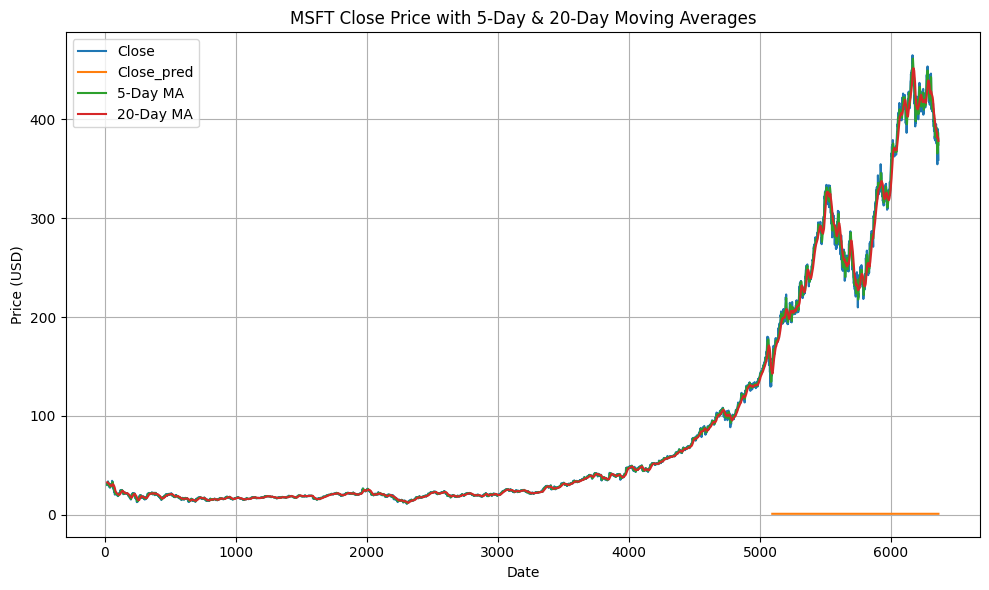

In [25]:
import matplotlib.pyplot as plt

# 1. Close price with MA5 & MA20
plt.figure(figsize=(10, 6))
plt.plot(MSFT_clean_df.index, MSFT_clean_df['close_MSFT'], label='Close')
plt.plot(y_test.index, y_pred, label='Close_pred')
plt.plot(MSFT_clean_df.index, MSFT_clean_df['MA5'],       label='5-Day MA')
plt.plot(MSFT_clean_df.index, MSFT_clean_df['MA20'],      label='20-Day MA')
plt.title("MSFT Close Price with 5-Day & 20-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

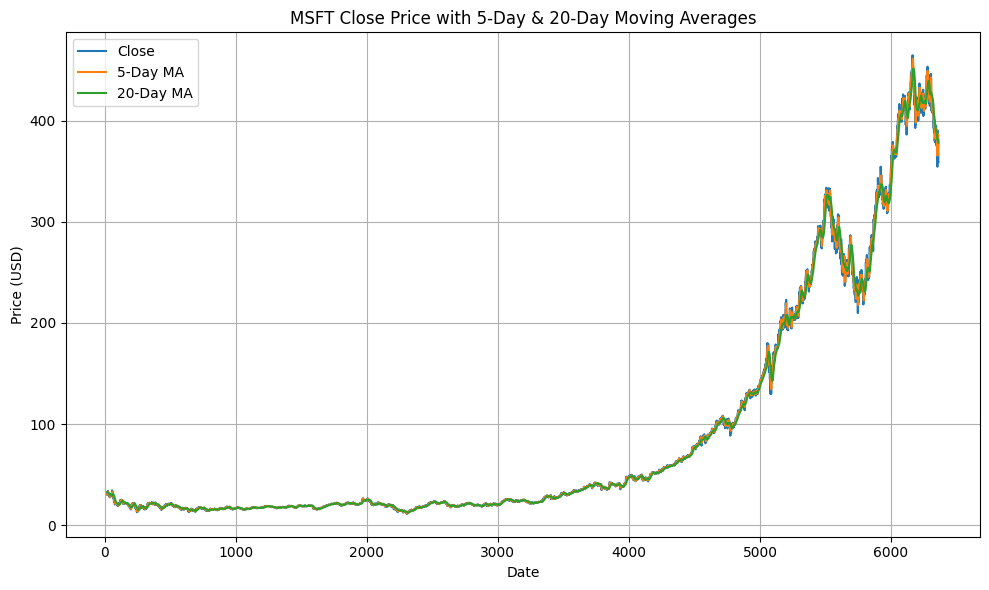

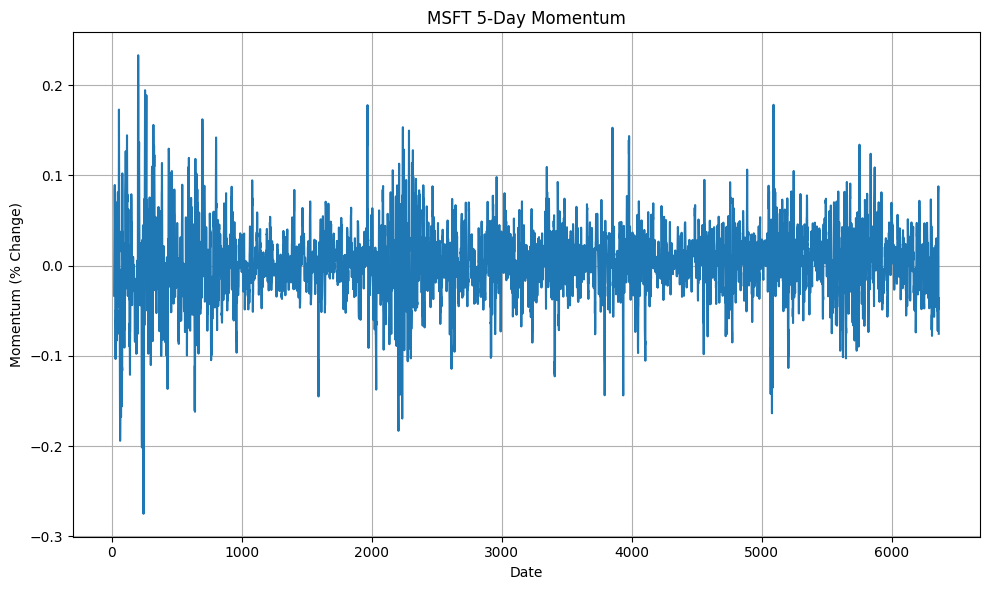

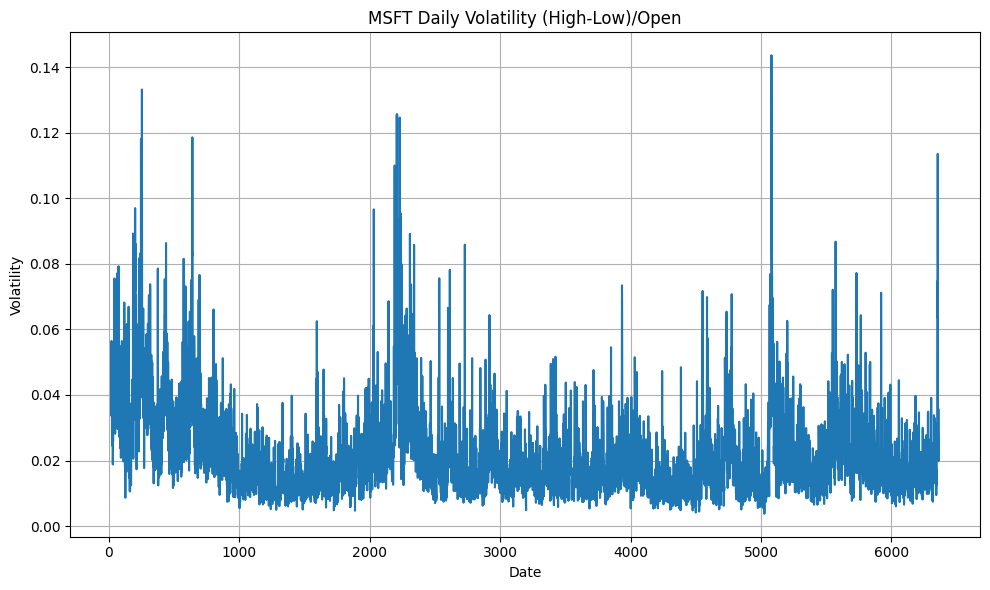

In [23]:
import matplotlib.pyplot as plt

# 1. Close price with MA5 & MA20
plt.figure(figsize=(10, 6))
plt.plot(MSFT_clean_df.index, MSFT_clean_df['close_MSFT'], label='Close')
plt.plot(MSFT_clean_df.index, MSFT_clean_df['MA5'],       label='5-Day MA')
plt.plot(MSFT_clean_df.index, MSFT_clean_df['MA20'],      label='20-Day MA')
plt.title("MSFT Close Price with 5-Day & 20-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 5-Day Momentum
plt.figure(figsize=(10, 6))
plt.plot(MSFT_clean_df.index, MSFT_clean_df['Mom5'])
plt.title("MSFT 5-Day Momentum")
plt.xlabel("Date")
plt.ylabel("Momentum (% Change)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Daily Volatility (High-Low)/Open
plt.figure(figsize=(10, 6))
plt.plot(MSFT_clean_df.index, MSFT_clean_df['volume_MSFT'])
plt.title("MSFT Daily Volatility (High-Low)/Open")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()

